# **PROJECT: TEXT GENERATION USING LSTM**

## 0. Setup

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade streamlit


In [ ]:
import tensorflow as tf
import streamlit as st

print()
print("TensorFlow version:", tf.__version__)
print("Streamlit version:", st.__version__)



## 1. Import All Dependencies

In [1]:
# module for building LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow.keras.utils as ku

# set the seed (initial starting point for PRNG(pseudorandom number generator) to maintaing the consistency during generating the random numbers)
from numpy.random import seed
tf.random.set_seed(2)
seed(1)

# computaional module
import pandas as pd
import numpy as np
import string
import os

import json

# to ignore the warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = FutureWarning)

2024-04-21 16:27:27.150007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 16:27:27.150061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 16:27:27.151591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# specifying the directory path
BASE_DIR = '/kaggle/input/nyt-comments/'
WORKING_DIR = '/kaggle/working/'


## 2. Load the dataset
#### we are using the NewYork Times Comments and Headlines

In [3]:
os.listdir(BASE_DIR)

['CommentsFeb2018.csv',
 'ArticlesFeb2017.csv',
 'CommentsApril2018.csv',
 'ArticlesJan2017.csv',
 'ArticlesMay2017.csv',
 'CommentsJan2017.csv',
 'CommentsMarch2017.csv',
 'CommentsMay2017.csv',
 'CommentsMarch2018.csv',
 'CommentsApril2017.csv',
 'ArticlesMarch2017.csv',
 'ArticlesApril2017.csv',
 'CommentsFeb2017.csv',
 'ArticlesJan2018.csv',
 'ArticlesFeb2018.csv',
 'ArticlesMarch2018.csv',
 'CommentsJan2018.csv',
 'ArticlesApril2018.csv']

In [4]:
# gather all the news headlines and stored it
all_Headlines = []

for filename in os.listdir(BASE_DIR):
    if 'Articles' in filename:
        article_df = pd.read_csv(BASE_DIR + filename)
        all_Headlines.extend(list(article_df.headline.values))
        break
        
# removed the articles without headlines
all_Headlines = [headline for headline in all_Headlines if headline != 'Unknown']
len(all_Headlines)

829

## 3. Data Preparation

#### 3.1 Data Cleaning :
##### Remove the punctuations and lower casting all the words

In [5]:
# define the function for data cleaning
def clean_data(text):
    text = "".join(letter for letter in text if letter not in string.punctuation).lower()
    text = text.encode("utf-8").decode('ascii', 'ignore')
    return text
    
# create corpus
corpus = [clean_data(headline) for headline in all_Headlines]
corpus[:10]
    

['nfl vs politics has been battle all season long',
 'voice vice veracity',
 'a standups downward slide',
 'new york today a groundhog has her day',
 'a swimmers communion with the ocean',
 'trail activity',
 'super bowl',
 'trumps mexican shakedown',
 'pences presidential pet',
 'fruit of a poison tree']

#### 3.2  Tokenization: 
##### Tokenized the sequences into tokens

In [6]:
# create instance of tokenizer 
tokenizer = Tokenizer()

# define the funtion to perform the tokenization on our data
def tokenized_sequence(corpus):
    tokenizer.fit_on_texts(corpus)
    vocab_size = len(tokenizer.word_index) + 1
    
    # convert data to sequence of token ( N-Grams sequences)
    input_sequences = []
    for line in corpus:
        list_of_token = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(list_of_token)):
            n_gram_seq = list_of_token[:i+1]
            input_sequences.append(n_gram_seq)
    
    return input_sequences, vocab_size
    

# implement this function on our data
input_sequences, vocab_size = tokenized_sequence(corpus)
input_sequences[:10]

[[660, 117],
 [660, 117, 72],
 [660, 117, 72, 73],
 [660, 117, 72, 73, 661],
 [660, 117, 72, 73, 661, 662],
 [660, 117, 72, 73, 661, 662, 63],
 [660, 117, 72, 73, 661, 662, 63, 29],
 [660, 117, 72, 73, 661, 662, 63, 29, 210],
 [211, 663],
 [211, 663, 664]]

### Save the tokenizer

In [7]:
# Save the tokenizer to a JSON file
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json))

#### 3.3 Padding the Sequences and split the data into training and target data
##### padding sequences is crucial as it ensure that all the vectors are of same size
###### padding = 'pre' --> add zeros at begining of each sequence

In [8]:
# define the function to padd the sequences on our data
def padded_sequences(input_sequences):
    max_seq_len = max([len(x) for x in input_sequences])
    input_seq = np.array(pad_sequences(input_sequences, maxlen = max_seq_len, padding = 'pre'))
    
    # split sequence into the input data and label data
    input_data, label_data = input_seq[:,:-1], input_seq[:,-1]
    label_data = ku.to_categorical(label_data, num_classes = vocab_size)
    
    return input_data, label_data, max_seq_len
    
#  padded the sequences
input_data, label_data, max_seq_len = padded_sequences(input_sequences)

## 4. Text Generation using LSTM

#### 4.1 Build Model
##### Model Architecture: Three major layer (Embedding Layer, LSTM, Dense) added into the model.


In [9]:
def build_model(max_seq_len, vocab_size):
    input_len = max_seq_len - 1
    model = Sequential()
    
    # Add Input layer <-- Embedding Layer
    model.add(Embedding(vocab_size, 10))
    
    # Add hidden layer <-- LSTM and Dropout layers
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    
    # Add output layer
    model.add(Dense(vocab_size, activation = 'softmax'))
    
    # compile model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    
    return model


In [10]:
model = build_model(max_seq_len, vocab_size)

# fit the model
history = model.fit(input_data, label_data, epochs = 500, verbose = 5)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

### Save the model

In [11]:
model.save('model.h5')

### Plot model 

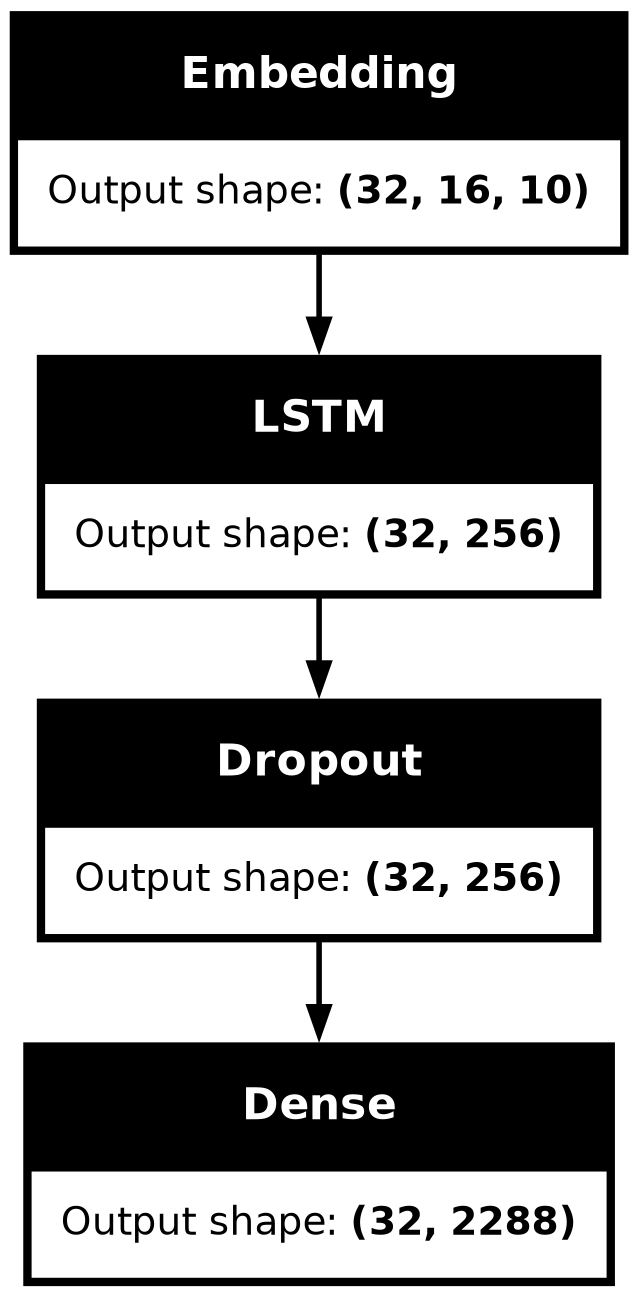

In [12]:
ku.plot_model(model, show_shapes = True)

## 5. Evaluate The Model

In [13]:
def evaluate_model_accuracy(model, input_data, label_data):
    # Predict classes for input data
    predictions = model.predict(input_data)
    
    # Convert predicted probabilities to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Convert one-hot encoded labels to class indices
    true_classes = np.argmax(label_data, axis=1)
    
    # Compare predicted classes with true classes
    correct_predictions = np.sum(predicted_classes == true_classes)
    total_samples = len(true_classes)
    
    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    
    return accuracy

# Usage
accuracy = evaluate_model_accuracy(model, input_data, label_data)
print("Accuracy:", accuracy)


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8391285211267606


In [14]:
def evaluate_model_loss(model, input_data, label_data):
    # Evaluate model loss
    loss = model.evaluate(input_data, label_data, verbose=0)
    
    return loss

# Usage
loss = evaluate_model_loss(model, input_data, label_data)
print("Loss:", loss)


Loss: 1.0006893873214722


## 6. TEST MODEL

#### 5.1 Generating the text 

In [15]:
def generate_text(seed_text, num_next_words, model, max_sequence_length):
    for _ in range(num_next_words):
        
        # tokenized the input model
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # padd the seqeunces
        token_list = pad_sequences([token_list], maxlen = max_sequence_length, padding = 'pre')
        
        # feed the preprocessed input data into the model to generate the next word
        predict_probs = model.predict(token_list)[0]
        predict_index = np.argmax(predict_probs)
        
        # decode the sequence into human readable format
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predict_index:
                output_word = word
                break
            
        # update the seed text (input_taken + generate word --> to predict next word)
        seed_text += " " + output_word
        
    return seed_text.title()
                

## 7. Results

In [16]:
print(max_seq_len)

17


In [17]:
# test the model

print('------------- Generated Text -----------------------')
print(generate_text('i am', 5, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('Dear', 5, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('Who are', 5, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('Nothings', 5, model, max_seq_len))
print()

print('------------- Generated Text -----------------------')
print(generate_text('whats', 5, model, max_seq_len))
print()



------------- Generated Text -----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
I Am Must Press A Twostate Path

------------- Generated Text -----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dear Gains For Republicans On Bold

------------- Generated Text -----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Who Are We A Coop Liable Concept

------------- Generated Text -----------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


# Streamlit App

## 1. Download the streamlit and local tunnel

In [ ]:
!pip install streamlit

In [ ]:
!npm install -g localtunnel

## 1.1 Create app.py file

In [ ]:
%%writefile app.py

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import tensorflow.keras.utils as ku
import streamlit as st
import tensorflow as tf
import json

# Load the tokenizer from the JSON file
with open("tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_json = json.loads(f.read())
    tokenizer = tokenizer_from_json(tokenizer_json)

# Function to generate text based on input sequence
def generate_text(seed_text, num_next_words, model, max_sequence_length):
    for num in range(num_next_words):
        
        # Tokenize the input sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Pad the sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        
        # Feed the preprocessed input data into the model to generate the next word
        predicted_probs = model.predict(token_list)[0]
        
        # Find the index of the word with the highest probability
        predicted_index = np.argmax(predicted_probs)
        
        # Find the word corresponding to the predicted index
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
            
        # Update the seed text (input taken + generated word --> to predict next word)
        seed_text += " " + output_word
    
    return seed_text.title()

# Streamlit app
def main():
    st.title("Text Generation App")
    
    # load the model
    model = tf.keras.models.load_model('model.h5')
    
    # Input sequence from the user
    input_sequence = st.text_input("Enter the input sequence:")
    
    # Number of words to generate
    num_next_words = st.slider("Number of next words to generate:", min_value=1, max_value=10, value=5)
    
    # Specifying the max sequence length
    max_seq_len = 17
    
    # Button to generate text
    if st.button("Generate Text"):
        # Generate text based on the input sequence
        generated_text = generate_text(input_sequence, num_next_words, model, max_seq_len)
        
        # Display the generated text
        st.write("Generated Text:", generated_text)

if __name__ == "__main__":
    main()

## 1.3 Run Streamlit app 

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


In [ ]:
! streamlit --version

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501